## Domača naloga 6
Marko Tacer, 23222087

Podatki: \
eksponentno okno: $p = 0,14$\
force okno: $I_w = 0,2$

Pri vaji smo si pogledali obdelavo izmerjenih signalov na prejšnji vaji. Za vsako izemd točk smo naredili FRFje, pred tem pa smo isgnale "popravili" s pomočjo oken.

In [1]:
import lvm_read
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import pyEMA;
%matplotlib inline

C:\Users\marko\AppData\Roaming\Python\Python39\site-packages\pyEMA\__init__.py:12: UserWarning: This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.
  warnings.warn('This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.')


In [2]:
file = f'10signal.lvm'
loaded_data = lvm_read.read(file)
loaded_data[0]['data'].shape[0]
S = loaded_data[0]['data'].T
t = S[0]
raz = S[0].size

### Priprava: Exponential okno

In [3]:
p = 0.14 # 1 %
tau = -(len(t) - 1) / np.log(p)
w_exponential = signal.windows.exponential(len(t), center=0, tau=tau, sym=False)

### Priprava: Force okno

In [4]:
l_w = 0.2
N_w = int(l_w * len(t))
w_force = np.zeros_like(t)
w_force[:N_w] = signal.windows.tukey(len(t)*2, alpha=0.02)[-N_w:]
w_f = w_force * w_exponential

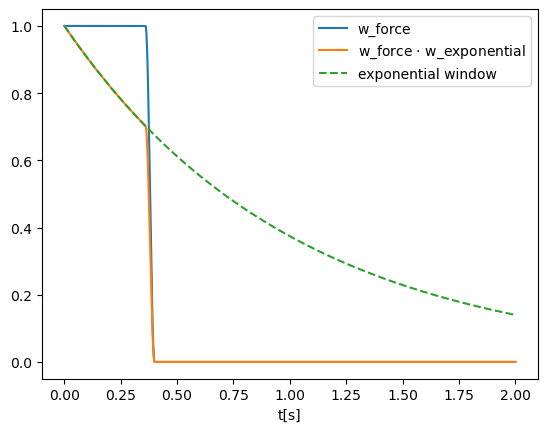

In [5]:
# Izris
plt.plot(t, w_force, label='w_force')
plt.plot(t, w_f, label=f'w_force $\cdot$ w_exponential')
plt.plot(t, w_exponential, '--', label='exponential window')
plt.xlabel('t[s]')
plt.legend()
plt.show()

### Definicija funcij in prikaz obdelanih časovnih vrst

Spodaj definiramo katere segmente posamezne točke obravnavamo. Izberem za vsako točko en segment z indeksom, ki ga shranim v "j"

In [6]:
j = ([0, 1, 0, 2, 4, 0, 3, 5, 10, 1])   # Indeksi izbranega segmenta za posamezno točko

Prirpava posameznih funkcij, za lažjo uporabo v "for zanki" 

In [7]:
def oknjenje_signala(file_path, index=0): # definiram si funkcijo, ki mi iz izmerjenih odzivov in pospeškov 
    # vrne oknjene (plus prebere sam lvm file) 
    '''
    index: segment
    S[0] čas
    S[1] sila
    S[2] odziv (pospešek)
    
    return t, x_a, x_f
    '''
    
    # file_path = f'{h+1}signal.lvm'
    loaded_data = lvm_read.read(file_path)
    S = loaded_data[index]['data'].T
    tao = S[0][0] # začetni čas t0
    t = S[0] - tao
    
    x_f = S[1]
    x_a = S[2]
    
    x_f2 = x_f * w_exponential      # množenje z eksponentnim oknom
    x_a2 = x_a * w_f                # množenje s force oknom in eksponentnim
    
    return t, x_a, x_f

In [8]:
def FPF(t, x_a, x_f): # s to funkcijo si naredim FRF (ali FPFje), da lahko enostavno peljem for-zanko
    '''
    t, x_a, x_f - array
    return FPF, h, X_a, X_f, freq
    '''

    dt = t[1] - t[0]
    freq = np.fft.rfftfreq(len(t), dt)
    
    X_a = np.fft.rfft(x_a, norm="forward");
    X_f = np.fft.rfft(x_f, norm="forward");
    FPF = X_a/X_f
    h = np.fft.irfft(FPF);
    return FPF, h, X_a, X_f, freq

Spodaj si samo pripravim prazne arraye, kamor bom s for zanko pisal posamezne veličine za posamezne točke.

In [9]:
t_sk = np.zeros(shape=(len(j), raz))
a_sk = np.zeros(shape=(len(j), raz))
x_sk = np.zeros(shape=(len(j), raz))
A_sk = np.zeros(shape=(len(j), raz//2+1), dtype=complex)
X_sk = np.zeros(shape=(len(j), raz//2+1), dtype=complex)
FPF_sk = np.zeros(shape=(len(j), raz//2+1))
h_sk = np.zeros(shape=(len(j), raz))
freq_sk = np.zeros(shape=(len(j), raz//2+1))

#### Dejanski izračun za vse točke

In [10]:
for i in np.arange(10):
    t_sk[i, :], a_sk[i, :], x_sk[i, :] = oknjenje_signala(f'{i+1}signal.lvm', index=j[i])
    FPF_sk[i, :], h_sk[i, :], A_sk[i, :], X_sk[i, :], freq_sk[i, :] = FPF(t_sk[i, :], a_sk[i, :], x_sk[i, :]);

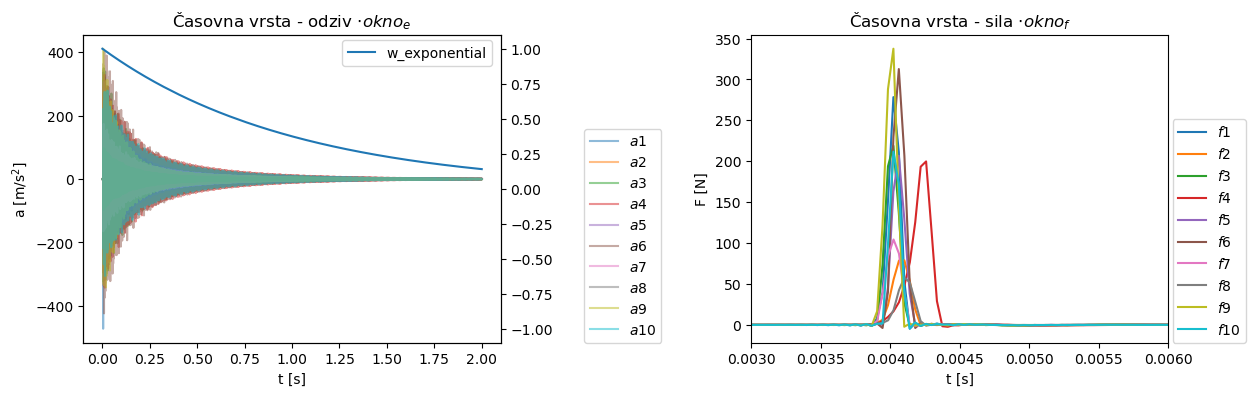

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
fig.subplots_adjust(wspace=0.6)

for i in np.arange(10): 
    
    ax1.set_title(f'Časovna vrsta - odziv $\cdot okno_e$')
    ax2.set_title(f'Časovna vrsta - sila $\cdot okno_f$')
    
    ax1.plot(t_sk[i], a_sk[i], alpha=0.5, label=f'$a {i+1}$')
    ax2.plot(t_sk[i], x_sk[i], alpha=1, label=f'$f {i+1}$')

    ax1.legend(loc=(1.2, 0))
    ax2.legend(loc=(1.01, 0))

    ax1.set_xlabel('t [s]');
    ax1.set_ylabel('a [m/s$^2$]')
    
    ax2.set_xlabel('t [s]');
    ax2.set_ylabel('F [N]')
    ax2.set_xlim(0.003, 0.006) # tudi ta je oknjen, a okno ni prikazano, saj bi potreboval novo x-os

ax3 = ax1.twinx()
ax3.plot(t_sk[0], w_exponential, label='w_exponential')
ax3.legend(loc=(0.62, 0.9))
ax3.set_ylim(-1.1, 1.1);

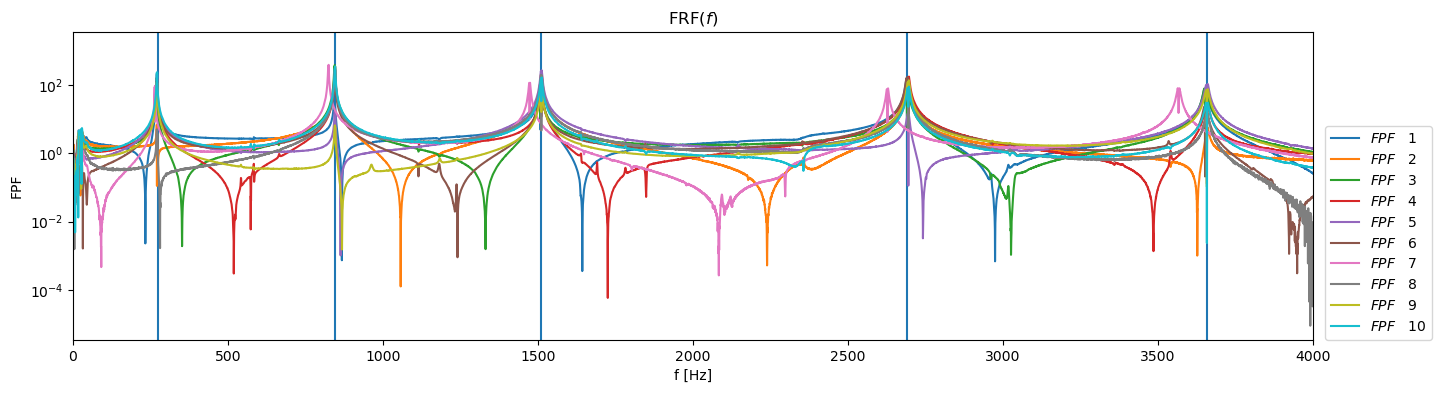

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))
for i in [275,845,1509,2690,3660]:      # gledam, kje bi lahko bile lasne frekvence
                                        # vidimo tudi, da meritev 7 nekoliko odstopa od ostalih
    ax.axvline(x=i, ymin=0.001, ymax=100)
for i in np.arange(10):
    ax.semilogy(freq_sk[i], abs(FPF_sk[i]), alpha=1, label=f'$FPF \quad {i+1}$')
    ax.set_title('FRF($f$)')

    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('f [Hz]');
    ax.set_ylabel('FPF')
    ax.set_xlim(0, 4000)

### Lastne oblike (in frekvence)

In [17]:
inst = pyEMA.Model(frf=FPF_sk, freq=freq_sk[i]) #naredimo instanco
inst.get_poles()    
aprox_f =  [275, 845, 1509, 2690, 3660] # definiramo približke lastnih frekvenc, ki smo jih iskali zgoraj

100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.27it/s]


In [18]:
inst.select_closest_poles(aprox_f) # iščemo lastne frekvence okoli približno doloženih

100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.74it/s]


In [19]:
frf_rec, modal_const = inst.get_constants(whose_poles='own', FRF_ind='all')
inst.print_modal_data()

   Nat. f.      Damping
-----------------------
1)  270.8	0.0023
2)  844.3	0.0000
3) 1508.9	0.0007
4) 2690.8	0.0005
5) 3652.4	0.0006


#### Izris lastnih oblik

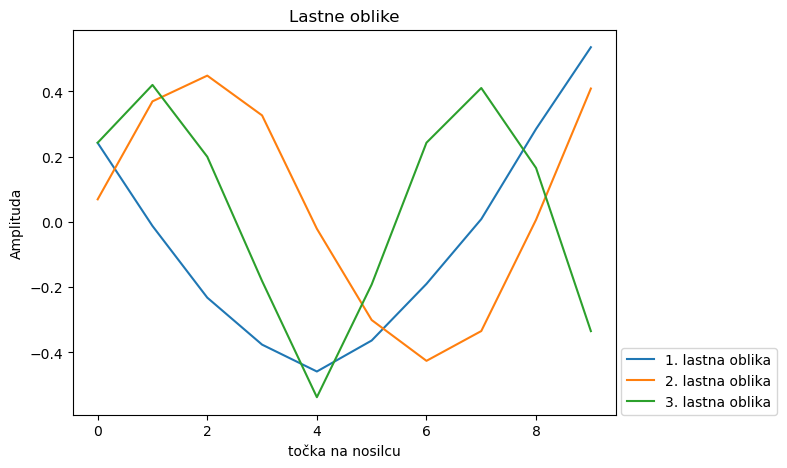

In [21]:
plt.figure(figsize=(7,5))
for i in range(3):
    plt.plot(inst.normal_mode()[:,i],label=f'{i+1}. lastna oblika');
    plt.legend(loc = (1.01, 0))
    plt.xlabel('točka na nosilcu')
    plt.ylabel('Amplituda')
    plt.title('Lastne oblike');